## Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

Plan:
* Study how to use OpenAI gym
* Basic prototype of evolutionary strategies that works in one thread on CartPole
* Modify the code to make them work in parallel
* Use the algorithm to solve the LunarLander
* Analyse the influence of hyperparameters

In [23]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
 
%matplotlib inline

# OpenAI gym environment

In [25]:
import gym

tmp_env = gym.make("CartPole-v0")
tmp_env.reset()

print("Observation space:", tmp_env.observation_space)
print("Action space:", tmp_env.action_space)
state_size = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Discrete(2)


### How to interact with the environment

In [26]:
print("Initial observation:", tmp_env.reset())

new_s, reward, done, _ = tmp_env.step(0)
print("At each step it returns:")

print("new observation code:", new_s)
print("reward:", reward)
print("is game over?:", done)

Initial observation: [ 0.02662419  0.03951516  0.0399158  -0.0469323 ]
At each step it returns:
new observation code: [ 0.02741449 -0.15615575  0.03897715  0.25807241]
reward: 1.0
is game over?: False


### Display an episode

In [30]:
def display_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info = env.step(a)
        s = new_s
        total_reward += r
        
        if done:
            break
            
    return total_reward

### Random policy

In [31]:
class RandomPolicy:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def get_action(self, s):
        return np.random.choice(self.n_actions)

In [36]:
total_reward = display_session(tmp_env, RandomPolicy(n_actions))
print('Total reward: ', total_reward)

Total reward:  21.0


# The challenge of the day

![Algorithm](https://i.ibb.co/zFm6BrB/Screenshot-from-2021-09-17-13-38-00.png)

### Model evaluation

In [74]:
def generate_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info = env.step(a)
        total_reward += r
        s = new_s
        
        if done:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=500):
    return np.mean([generate_session(env, agent, t_max) for _ in range(n)])

### Modification of the model using a noise 

In [75]:
def add_noise_to_model(model, noise, copy=False):
    if copy:
        model = deepcopy(model)

    for param, param_noise in zip(model.parameters(), noise):
        param.data += torch.tensor(param_noise)

    return model

### Controller of the evolution

#### Task 1: Implement the algorithm

In [130]:
class EvolutionManager:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, n_threads = 1, normalize=True):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.n_threads = n_threads
        self.mean_reward_history = []
        
        self.env = get_env_function()
        
    def get_noised_model(self, model):
        noise = [self.std * np.random.randn(*p.shape) for p in model.parameters()]
        return add_noise_to_model(model, noise, True), noise

    def optimize(self, model, noises, rewards):
        total_noise = []
        for i, p in enumerate(model.parameters()):
            total_noise.append(np.zeros(p.shape))
            for noise, r in zip(noises, rewards):
                total_noise[-1] += (self.lr / self.std**2) * (noise[i] * r) / len(noises)
        add_noise_to_model(model, total_noise, False)
    
    def step(self, model):
        noises = []
        rewards = []
        noise_models = []
        for i in range(self.n_samples):
            noised_model, noise = self.get_noised_model(model)
            noises.append(noise)
            noise_models.append(noised_model)
        
        if self.n_threads == 1:
            for i in range(self.n_samples):
                rewards.append(score(self.env, noise_models[i]))
        else:
            rewards = np.array(Parallel(n_jobs=self.n_threads)(delayed(score)
                       (deepcopy(self.env), noise_models[i]) \
                       for i in range(self.n_samples)))

        self.update_log(rewards)

        rewards = np.array(rewards)
        if self.normalize:
            rewards -= np.mean(rewards)
            rewards /= np.std(rewards) + 1e-3

        self.optimize(model, noises, rewards)
        
    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()
    

#### Task 2: Implement a neural network-based policy

### Neural policy

In [127]:
class MLPPolicy(nn.Module):
    def __init__(self, input_size, n_actions, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions, bias=False)
        )

    def get_action(self, s):
        return int(torch.argmax(self.model(s.unsqueeze(0))[0]).numpy())

### Environment 1: CartPole-v0

In [132]:
def get_env_function():
    env = gym.make('CartPole-v0').env
    return env
tmp_env = get_env_function()

In [133]:
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n
model = MLPPolicy(n_states, n_actions, 128)

last mean reward = 500.000


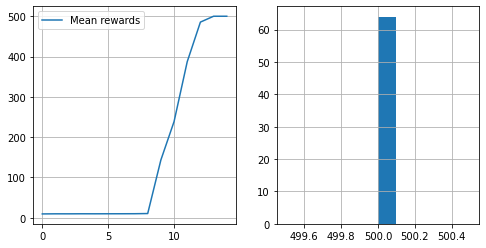

31.42000985145569


In [134]:
algorithm = EvolutionManager(get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True)

for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

In [135]:
display_session(tmp_env, model, t_max=500)

500.0

#### Task 3: Implement and compare the parallelized version of the algorithm

In [136]:
model = MLPPolicy(n_states, n_actions, 128)

last mean reward = 443.627


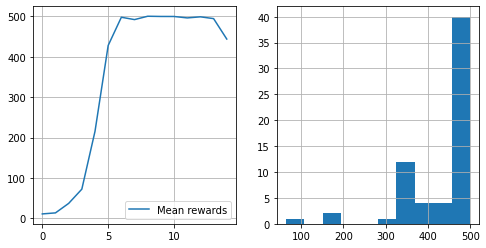

25.57366442680359


In [137]:
algorithm = EvolutionManager(get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True, n_threads=-1)

for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

### Environment 2: LunarLanderContinuous-v2

In [142]:
class MLPContinuousPolicy(nn.Module):
    def __init__(self, input_size, n_actions, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions, bias=False)
        )

    def get_action(self, s):
        with torch.no_grad():
            return self.model(s.unsqueeze(0))[0].detach().numpy()

last mean reward = -132.813


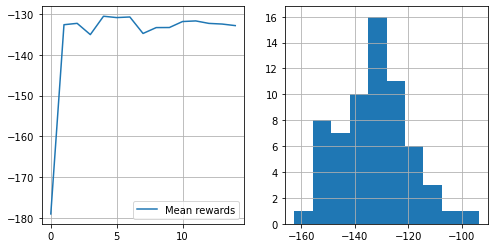

KeyboardInterrupt: ignored

In [143]:
def get_env_function():
    env = gym.make('LunarLanderContinuous-v2').env
    return env
tmp_env = get_env_function()
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.shape[0]
model = MLPContinuousPolicy(n_states, n_actions, 128)
algorithm = EvolutionManager(get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True, n_threads=1)
for i in range(1000):
    algorithm.step(model)

297.1928817226966

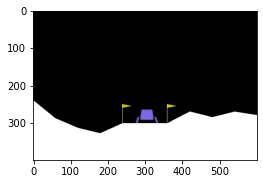

In [ ]:
display_session(tmp_env, model, t_max=500)

### Task 3: Hyperparameter's analysis

Now we are going to do some experimental analysis of the algorithm.

Plan:
- to learn something about the *std* parameter
- to learn something about the *learning rate* parameter
- to learn something about the *n_samples* parameter